In [1]:
%load_ext autoreload
%autoreload 2
import networkx as nx
from sklearn.linear_model import LogisticRegression
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import causalicp as icp
r = np.random  # Random generator
r.seed(1)
from pm4py.algo.discovery.dcr_discover import algorithm as dcr_alg
from pm4py.util.external_functions import *
from data_aware_helper import *

In [ ]:
sepsis = pm4py.read_xes('/home/vco/Datasets/Sepsis Cases - Event Log.xes')

# For data attributes with the same name across events
 for data attributes that are named the same use the event as a prefix. then it is a different variable. (if they are the same accross events consider removing duplicate - keep the first one in the precedence

In [2]:
road_traffic = pm4py.read_xes('/home/vco/Datasets/Road_Traffic_Fine_Management_Process.xes.gz')
road_traffic_train, road_traffic_test = temporal_split(road_traffic,.3)
events = set(road_traffic_train['concept:name'].unique())
data_attributes = set(road_traffic_train.columns).difference({'org:resource','lifecycle:transition','concept:name','time:timestamp','case:concept:name'})
event_data_attributes = {}
for event in events:
    event_data_attributes[event] = extract_event_data_attributes(road_traffic_train,event,data_attributes)
domain_knowledge = {
    'Insert Fine Notification': {'lastSent':'categorical','notificationType':'categorical'},
    'Payment': {'paymentAmount':'numerical','totalPaymentAmount':'numerical'},
    'Appeal to Judge':{'dismissal':'categorical','matricola':'ignore'},
    'Add penalty': {'amount':'numerical'},
    'Send Appeal to Prefecture': {'dismissal': 'categorical'},
    'Send Fine': {'expense':'numerical'},
    'Create Fine': {'vehicleClass':'categorical','dismissal':'categorical','amount':'numerical','points':'categorical','article':'numerical','totalPaymentAmount':'numerical'}
}
events_no_data = set(road_traffic_train['concept:name'].unique()).difference(domain_knowledge.keys())

parsing log, completed traces ::   0%|          | 0/150370 [00:00<?, ?it/s]

# Make precedence probabilistic

[i] Mining with basic DisCoveR
[i] Converting to old event log!


/home/vco/Projects/pm4py-dcr/pm4py/utils.py:494: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


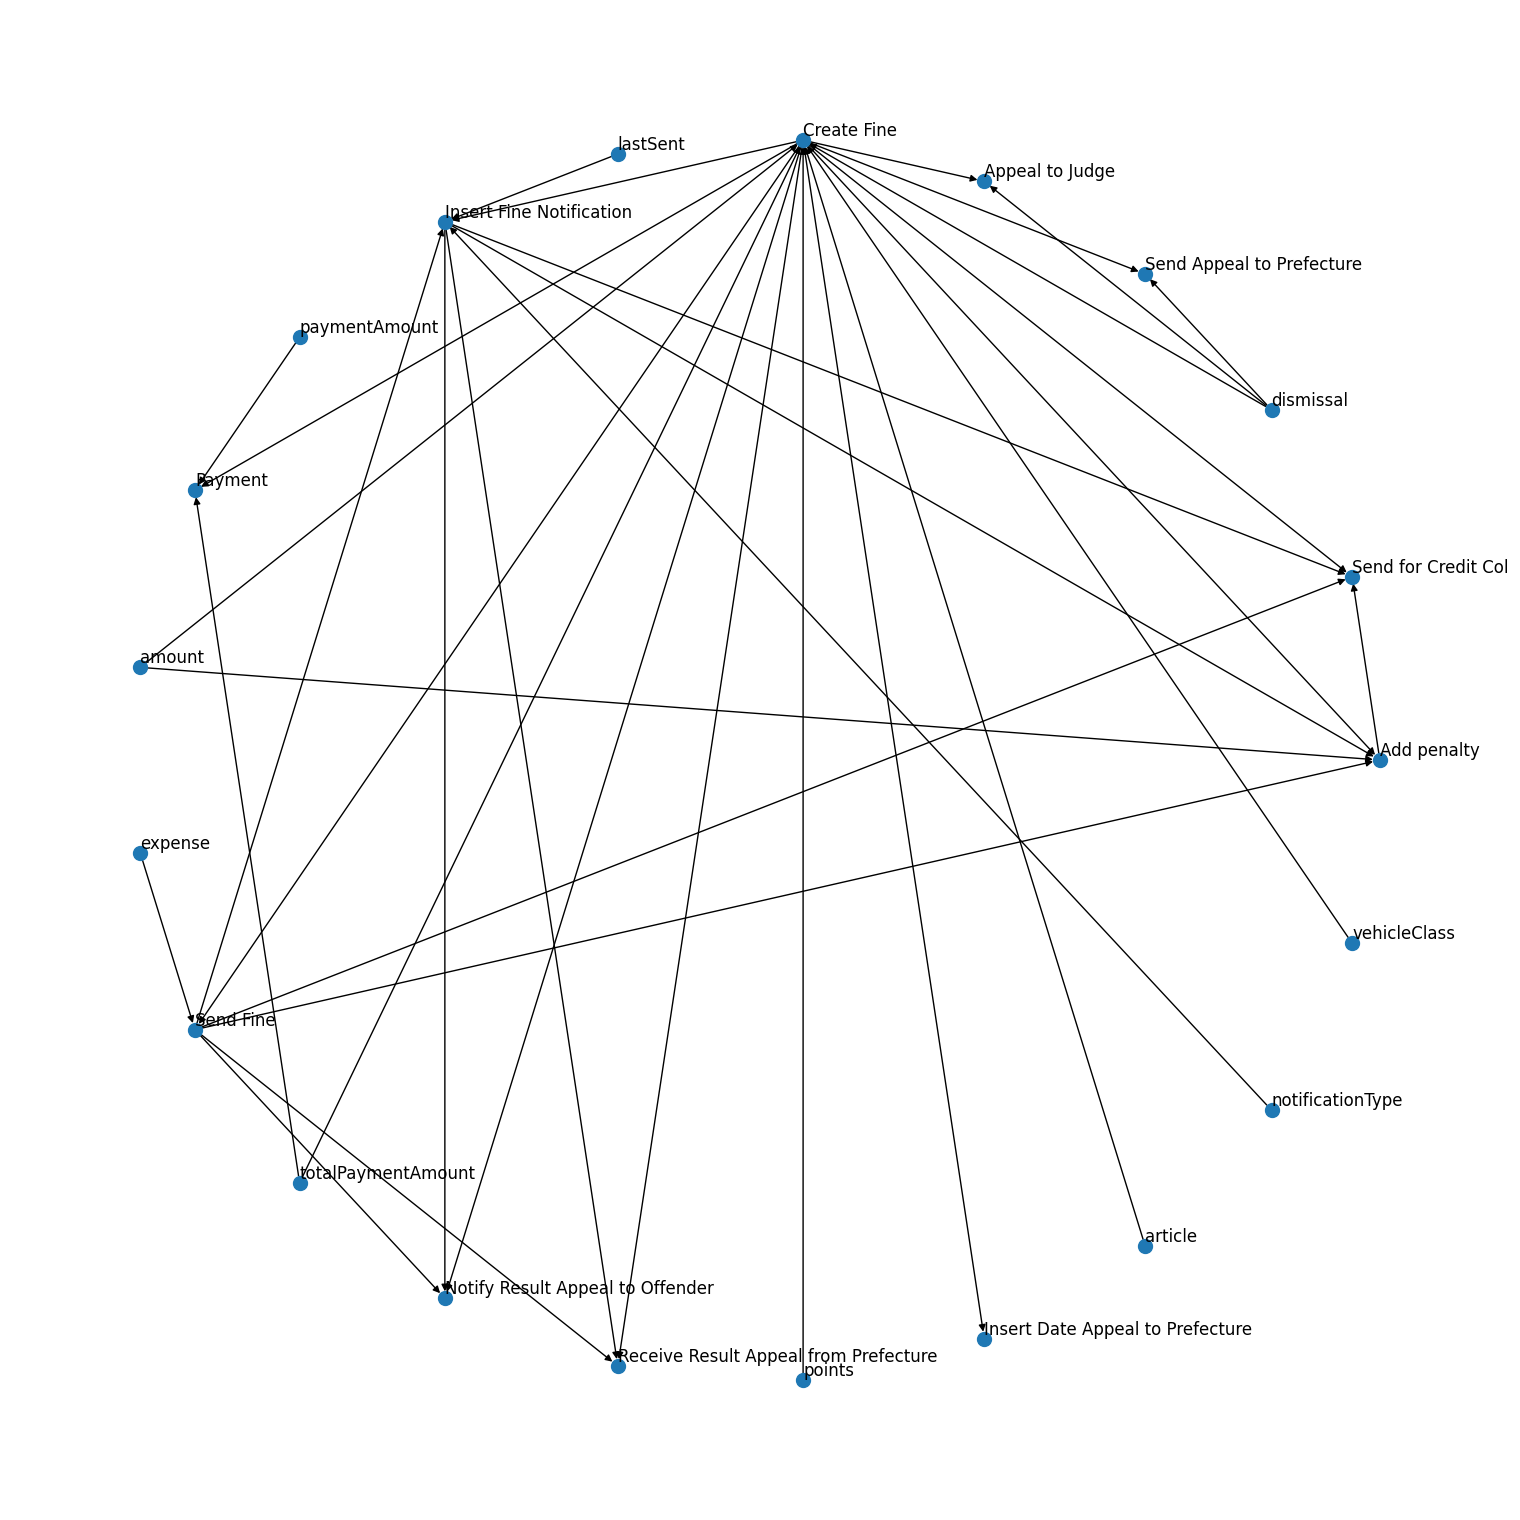

In [3]:
traffic_train_model, log_abs = dcr_alg.apply(road_traffic_train)
events_and_data = set(road_traffic_train['concept:name'].unique())
data_filler_adj_matrix = {}
i = len(events)
for e,a in domain_knowledge.items():
    ks = set()
    for k,v in a.items():
        if v!='ignore':
            events_and_data.add(k)
            i += 1
            ks.add(k)
    data_filler_adj_matrix[e] = ks
adj_matrix = np.array([[0 for i in range(len(events_and_data))] for j in range(len(events_and_data))])
idx_dict = {}
for i, e1 in enumerate(events_and_data):
    idx_dict[e1] = i
    for j, e2 in enumerate(events_and_data):
        if e1 in log_abs['precedenceFor'] and e2 in log_abs['precedenceFor'][e1]:
            adj_matrix[j][i] = 1

for e, ds in data_filler_adj_matrix.items():
    for d in ds:
        i = idx_dict[e]
        j = idx_dict[d]
        adj_matrix[j][i] = 1

labels = {i:l for i,l in enumerate(events_and_data)}
show_graph_with_labels(adj_matrix, labels)

# Event log to observational data

## For events (without timing information)
The execution of events is an unfair coin toss (Binomial distribution). 

For a given event check the number of cases this event has been observed in.
This gives the probability of observing an event.

Q: What to do with loops? Are these indicated by observing an event multiple times? When should repeated events be considered different events semantically (refine the event into multiple events)?

Extra: sequences (causality in the traditional sense), choices (conflict)

## For data attributes

### Numerical variables

Fit a parametric distribution from the observed numerical variables.

### Categorical variables

The observation of a certain value for a categorical variable is an unfair roll of the n-sided dice (Multinomial distribution). N is the number of categories.

## Why do this?

To use statistical tests for independence. Check if either the data or the events are independent variables.

# Overview

The main idea is: 

    Given an event log with data attributes and precedence relations and an event e which is part of the precedence relations, 
    how can we test whether the firing of certain preceeding events and their data attributes has an effect on the firing of event e.


Proposed solution:

    * Mine the precedence graph:
    * For each event e create an equation of it's firing as follows:
           - fire(e) = encode(preceding events) + encode(data attributes of preceding events) + noise
    *Given the set of equations (one for each event), test whether or not a change in the firing of preceding events and/or data attributes 
    has an effect on the firing of e
    * The idea is to split the event log according to certain data attribute values or the presence or absence of an event (2 or more splits)
    * For each split we learn a logistic regression function for the event e based on the equation and data
    * For each learned logistic regression function we compare them pairwise (using a statistical test, such as the chi-square test) to see whether 
    or not the change in variable (according to which the split was made) has an effect on the firing of e. 
    * If there is no change: we reject the variable (the variable has no effect on the firing of e)
    * If there is a change that is statistically significant (w.r.t. the chi-square test): we accept the variable
    * We return all the accepted variables (these are considered to have an effect on the firing of e - they are either other events and/or their 
    data attributes)

In [4]:
events = set(road_traffic_train['concept:name'].unique())
event_and_data_functions = {}
for event in events:
    event_and_data_functions[event] = extract_event_binomial(event,road_traffic_train)
attribute_events = {}
attribute_data_type = {}
for event, attributes in domain_knowledge.items():
    for attr, data_type in attributes.items():
        if attr not in attribute_events.keys():
            attribute_events[attr] = [event]
            attribute_data_type[attr] = data_type
        else:
            attribute_events[attr].append(event)

for attr, data_type in attribute_data_type.items():
    if data_type == 'categorical':
        event_and_data_functions[attr] = extract_categorical_data_attribute(attribute_events[attr],attr,road_traffic_train)
    if data_type == 'numerical':
        event_and_data_functions[attr] = extract_numerical_data_attribute(attribute_events[attr],attr,road_traffic_train)
observational_data_list = []

n = road_traffic_train['case:concept:name'].nunique()
for i, case_df in enumerate(road_traffic_train.groupby('case:concept:name')):
    data_dict = case_to_data_entry(case_df[1],events,attribute_data_type)
    observational_data_list.append(data_dict)
    print(f'[i] {i+1}/{n} cid: {case_df[0]}')
    if i+1 == 10000:
        break
event_x_cols = {}
event_y_cols = {}

instant_effects = True

for event in events:
    precedence_events = set(log_abs['precedenceFor'][event])
    precedence_data_attributes = set()
    for precedence_event in precedence_events:
        if precedence_event in data_filler_adj_matrix:
            precedence_data_attributes = precedence_data_attributes.union(set(data_filler_adj_matrix[precedence_event]))
    if instant_effects and event in data_filler_adj_matrix:
        precedence_data_attributes = precedence_data_attributes.union(set(data_filler_adj_matrix[event]))
    precedence_events = precedence_events.union(precedence_data_attributes)
    event_x_cols[event] = precedence_events
    event_y_cols[event] = event

event_model = {}
event_model_input = {}
x_cols = None
y_cols = None
always_executed_events = get_always_executed_events()
for event in events.difference(always_executed_events):
    observational_data = pd.DataFrame(observational_data_list,columns=list(event_and_data_functions.keys()))
    observational_data = observational_data.fillna(0)
    x_cols = deepcopy(event_x_cols[event])
    y_cols = deepcopy(event_y_cols[event])
    
    for attr, data_type in attribute_data_type.items():
        if data_type == 'categorical':
            onehot = pd.get_dummies(observational_data[attr],dummy_na=True,prefix=attr)
            observational_data = pd.concat([observational_data,onehot],axis=1)
            observational_data = observational_data.drop(attr,axis=1)

            x_cols.discard(attr)
            x_cols = x_cols.union(set(onehot.columns))
    clf = LogisticRegression(max_iter=1000)
    model = clf.fit(observational_data[list(x_cols)][:8000], observational_data[y_cols][:8000])
    print(f'[i] {event} score: {model.score(observational_data[list(x_cols)][8000:],observational_data[y_cols][8000:])}')
    event_model[event] = model
    event_model_input[event] = deepcopy(x_cols)
    event_model_input[event].add(y_cols)
    # y_hat = model.predict(observational_data[list(x_cols)][8000:])

[x] Event Send Appeal to Prefecture prob of success: 0.03
[x] Event Add penalty prob of success: 0.52
[x] Event Appeal to Judge prob of success: 0.00
[x] Event Send for Credit Collection prob of success: 0.38
[x] Event Insert Fine Notification prob of success: 0.52
[x] Event Send Fine prob of success: 0.69
[x] Event Create Fine prob of success: 1.00
[x] Event Notify Result Appeal to Offender prob of success: 0.01
[x] Event Receive Result Appeal from Prefecture prob of success: 0.01
[x] Event Payment prob of success: 0.46
[x] Event Insert Date Appeal to Prefecture prob of success: 0.03
[i] For data attribute: lastSent
[i] Data instance P prob of success 0.71
[i] Data instance N prob of success 0.25
[i] Data instance C prob of success 0.03
[i] Data instance nan prob of success 0.02
[i] For data attribute: notificationType
[i] Data instance P prob of success 1.00
[i] Data instance C prob of success 0.00


Fitting 10 distributions: 100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


[i] For data attribute: dismissal
[i] Data instance NIL prob of success 0.99
[i] Data instance # prob of success 0.01
[i] Data instance A prob of success 0.00
[i] Data instance G prob of success 0.00
[i] Data instance T prob of success 0.00
[i] Data instance D prob of success 0.00
[i] Data instance I prob of success 0.00
[i] Data instance N prob of success 0.00
[i] Data instance 5 prob of success 0.00
[i] Data instance @ prob of success 0.00
[i] Data instance C prob of success 0.00
[i] Data instance M prob of success 0.00
[i] Data instance E prob of success 0.00
[i] Data instance 3 prob of success 0.00
[i] Data instance B prob of success 0.00
[i] Data instance K prob of success 0.00
[i] Data instance U prob of success 0.00
[i] Data instance V prob of success 0.00
[i] Data instance F prob of success 0.00
[i] Data instance Q prob of success 0.00


Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 10.77it/s]


[i] For data attribute: vehicleClass
[i] Data instance A prob of success 0.98
[i] Data instance C prob of success 0.02
[i] Data instance M prob of success 0.00
[i] Data instance R prob of success 0.00
[i] For data attribute: points
[i] Data instance 0.0 prob of success 0.98
[i] Data instance 2.0 prob of success 0.01
[i] Data instance 5.0 prob of success 0.00
[i] Data instance 6.0 prob of success 0.00
[i] Data instance 3.0 prob of success 0.00
[i] Data instance 4.0 prob of success 0.00
[i] Data instance 10.0 prob of success 0.00
[i] Data instance 1.0 prob of success 0.00


Fitting 10 distributions: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


[i] 1/105259 cid: A1
[i] 2/105259 cid: A100
[i] 3/105259 cid: A10000
[i] 4/105259 cid: A10001
[i] 5/105259 cid: A10004
[i] 6/105259 cid: A10005
[i] 7/105259 cid: A10007
[i] 8/105259 cid: A10008
[i] 9/105259 cid: A10009
[i] 10/105259 cid: A1001
[i] 11/105259 cid: A10010
[i] 12/105259 cid: A10011
[i] 13/105259 cid: A10012
[i] 14/105259 cid: A10015
[i] 15/105259 cid: A10018
[i] 16/105259 cid: A10019
[i] 17/105259 cid: A1002
[i] 18/105259 cid: A10021
[i] 19/105259 cid: A10022
[i] 20/105259 cid: A10023
[i] 21/105259 cid: A10024
[i] 22/105259 cid: A10025
[i] 23/105259 cid: A10026
[i] 24/105259 cid: A10029
[i] 25/105259 cid: A10030
[i] 26/105259 cid: A10033
[i] 27/105259 cid: A10034
[i] 28/105259 cid: A10041
[i] 29/105259 cid: A10042
[i] 30/105259 cid: A10043
[i] 31/105259 cid: A10044
[i] 32/105259 cid: A10045
[i] 33/105259 cid: A10046
[i] 34/105259 cid: A10047
[i] 35/105259 cid: A10049
[i] 36/105259 cid: A10050
[i] 37/105259 cid: A10054
[i] 38/105259 cid: A10056
[i] 39/105259 cid: A10059
[i]

# 



In [5]:
observational_data[observational_data['Send Fine']==1]

,Send Appeal to Prefecture,Add penalty,Appeal to Judge,Send for Credit Collection,Insert Fine Notification,Send Fine,Create Fine,Notify Result Appeal to Offender,Receive Result Appeal from Prefecture,Payment,...,dismissal_N,dismissal_NIL,dismissal_nan,vehicleClass_A,vehicleClass_C,vehicleClass_M,vehicleClass_nan,points_0.0,points_2.0,points_nan
0,0,0,0,0,0,1,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0
1,0,1,0,1,1,1,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0
2,0,1,0,0,1,1,1,0,0,1,...,0,1,0,1,0,0,0,1,0,0
3,1,1,0,0,1,1,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0
4,0,1,0,1,1,1,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,0,0,0,0,0,1,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0
9995,0,1,0,0,1,1,1,0,0,1,...,0,1,0,1,0,0,0,1,0,0
9996,0,1,0,1,1,1,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0
9997,0,1,0,1,1,1,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0


In [33]:
data_no_noise

array([[  1.,   0.,   0.,   0., 157.,   1.,   0.],
       [  1.,   0.,   0.,   0., 157.,   1.,   0.],
       [  1.,   0.,   0.,   0., 157.,   1.,   0.],
       [  1.,   0.,   0.,   0., 157.,   1.,   0.],
       [  1.,   0.,   0.,   0., 157.,   1.,   0.],
       [  1.,   0.,   0.,   0.,   7.,   1.,   0.],
       [  1.,   0.,   0.,   0., 157.,   1.,   0.],
       [  1.,   0.,   0.,   0., 157.,   1.,   0.],
       [  1.,   0.,   0.,   0., 157.,   1.,   0.],
       [  1.,   0.,   0.,   0., 157.,   1.,   0.],
       [  1.,   0.,   0.,   0., 157.,   1.,   0.],
       [  1.,   0.,   0.,   0.,   7.,   1.,   0.],
       [  1.,   0.,   0.,   0., 157.,   1.,   0.],
       [  1.,   0.,   0.,   0., 157.,   1.,   0.],
       [  1.,   0.,   0.,   0., 157.,   1.,   0.],
       [  1.,   0.,   0.,   0., 157.,   1.,   0.],
       [  1.,   0.,   0.,   0., 157.,   1.,   0.],
       [  1.,   0.,   0.,   0., 157.,   1.,   0.],
       [  1.,   0.,   0.,   0., 157.,   1.,   0.],
       [  1.,   0.,   0.,   0.,

In [53]:
np.random.normal(0,1,data[1].shape)

array([[-0.23212508, -0.29434027, -0.46274022,  1.24055699, -0.16574686,
         1.08687685, -1.52298416],
       [ 0.40857295, -1.17014714,  0.26517151,  1.70906392,  0.0054511 ,
         0.78961759,  0.4938118 ],
       [ 2.40379158,  1.4089287 ,  1.40282962, -1.51993096,  0.21830107,
         0.44040039, -1.72026804],
       [-0.8981599 , -1.66012504, -0.08391048, -1.84849629,  0.88380481,
        -1.00806225, -0.48539947],
       [-0.63168217, -0.67207712, -0.93141089,  0.7901086 , -0.40691227,
        -0.76299196, -0.5113598 ],
       [ 0.06809836, -0.55576327, -0.8196286 ,  0.52015611,  0.09842767,
         0.49284541,  0.59461805],
       [ 0.20767413, -0.53392502, -0.11522755, -0.33839401,  0.56623811,
         0.47918735,  0.57462279],
       [ 0.52351557,  0.19353505,  0.59516892, -1.0520003 , -1.46599316,
         2.70542849,  0.20730963],
       [-1.44005392,  1.24468904, -0.81253603, -1.45511627,  0.72837531,
         0.5647203 ,  1.08151756],
       [-0.21015982,  1.0851

In [52]:
data[1]

array([[ 8.90834075e-01, -6.43039093e-02,  1.45667057e-01,
        -1.16754520e-02,  1.56910340e+02,  1.07140706e+00,
         9.45725045e-02],
       [ 8.66877647e-01,  3.39964997e-02,  1.08712577e-02,
        -5.67603180e-03,  1.56907959e+02,  1.01813282e+00,
        -4.85478069e-02],
       [ 1.07220870e+00,  9.88490558e-02,  1.09885258e-02,
        -1.01615320e-01,  1.56967216e+02,  9.59638289e-01,
         8.22068115e-03],
       [ 1.06415968e+00, -2.83404663e-02,  3.44885938e-02,
        -3.08594606e-02,  1.57090638e+02,  9.90071805e-01,
        -7.10589216e-03],
       [ 8.34222101e-01,  1.82198154e-01, -6.82495461e-02,
         4.78830724e-02,  1.57119465e+02,  9.61702938e-01,
        -7.14998562e-02],
       [ 9.78840743e-01, -5.72801968e-02, -5.01020223e-02,
        -3.31987499e-02,  7.13430361e+00,  9.96198622e-01,
        -2.31454327e-01],
       [ 1.09594165e+00, -8.78085220e-03, -1.80385620e-01,
         4.72477645e-02,  1.56889894e+02,  9.80753118e-01,
        -2.4309984

In [51]:
cols = ['points_0.0','points_2.0','points_nan','totalPaymentAmount','article','Send Fine','Payment']
for i in range(len(cols)):
    target_idx = i
    data = [observational_data[observational_data['Payment']==1][cols].to_numpy()[:100,:]]
    data += [observational_data[observational_data['Payment']==0][cols].to_numpy()[:100,:]]
    data_no_noise = deepcopy(data[1])
    noise = [np.random.normal(0,0.1,data[0].shape)]
    noise += [np.random.normal(0,0.1,data[1].shape)]
    data[0] = data[0] + noise[0]
    data[1] = data[1] + noise[1]
    res = icp.fit(data,target=target_idx, precompute=True, verbose=True, color=False)
    if res and res.estimate:
        print(f'{[cols[k] for k in res.estimate]} causal effects for "{cols[i]}"')

Tested sets and their p-values:
  set() accepted : 0.07049858906897721
  {1} accepted : 0.8676789126563893
  {2} accepted : 0.053753308381546315
  {3} accepted : 0.07564777335554629
  {4} accepted : 0.07014759239238355
  {5} accepted : 0.07896546455591125
  {6} accepted : 0.07681289188036847
  {1, 2} accepted : 0.90323775181069
  {1, 3} accepted : 1
  {1, 4} accepted : 0.8657637600792862
  {1, 5} accepted : 1
  {1, 6} accepted : 1
  {2, 3} accepted : 0.05706135950383026
  {2, 4} accepted : 0.05361472300706671
  {2, 5} accepted : 0.06254204847094849
  {2, 6} accepted : 0.0624503705880457
  {3, 4} accepted : 0.0756383646031938
  {3, 5} accepted : 0.07619993977558712
  {3, 6} accepted : 0.08063979129938659
  {4, 5} accepted : 0.07878791702177956
  {4, 6} accepted : 0.07634165029656881
  {5, 6} accepted : 0.07596900510684512
  {1, 2, 3} accepted : 1
  {1, 2, 4} accepted : 0.9018400339478061
  {1, 2, 5} accepted : 1
  {1, 2, 6} accepted : 1
  {1, 3, 4} accepted : 1
  {1, 3, 5} accepted : 1


# Toying around

## Random choice: Binomial, Multinomial etc.

In [ ]:
# each event has a 50% chance of occurring by default or a p chance
ef = {} # event functions
events = set(road_traffic_train['concept:name'].unique())
for event in events:
    # print(event)
    ef[event] = lambda p: r.choice([1,0],p=[p,(1-p)]) if p else r.choice([1,0])
# at runtime the probability of an event to fire changes as you execute the trace
p2 = lambda x: x
p = lambda x: x#*p2(0.7)
res = []
for i in range(10000):
    res.append(ef['Send Fine'](p(0.7)))
plt.hist(res,bins=2)

## Fitter and parametric distributions

In [ ]:
fine_list = box_plot_fine_amount(road_traffic_train)
dist_func, best_dist, fitted_params = fit_and_plot_fine_list(fine_list)
print(f'[i] Best fitting single distribution: {dist_func.name}')
print(f'[i] Params: {fitted_params}')